# Author : Owen Nda Diche

# Threshold Tuning & Decisioning (Churn Model)

## Objective
The model outputs **probabilities** of churn. To turn probabilities into actions, we must choose a **decision threshold**.

This notebook:
- Loads saved `y_test` and `y_proba` from the modeling notebook
- Visualizes **precision/recall trade-offs**
- Picks an operating threshold (Max F1 + Recall-target option)
- Summarizes business implications using confusion matrix counts


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)


## Load model outputs (no retraining)

From `03_modeling_random_forest.ipynb`, we save:
- `y_test` = true churn labels (0/1)
- `y_proba` = predicted probability of churn (class 1)

We load them here to focus only on threshold decisioning.


In [4]:
data = np.load("rf_eval_outputs.npz", allow_pickle=True)
y_test = data["y_test"].astype(int)
y_proba = data["y_proba"].astype(float)

print("Loaded:", y_test.shape, y_proba.shape)


Loaded: (2922,) (2922,)


## Why threshold tuning matters

With imbalanced churn (~10%), a default threshold of **0.5** often produces:
- High accuracy
- High precision
- Very low recall (misses most churners)

Instead, we select a threshold aligned to business goals:
- **Higher recall** if missing churn is costly
- **Higher precision** if incentives are expensive
- **Balanced F1** if we want a compromise


,threshold,precision,recall,f1
0,0.000,0.097194,1.000000,0.177168
1,0.002,0.097107,0.992958,0.176913
2,0.004,0.097544,0.992958,0.177638
3,0.006,0.098155,0.992958,0.178651
4,0.008,0.098205,0.982394,0.178560


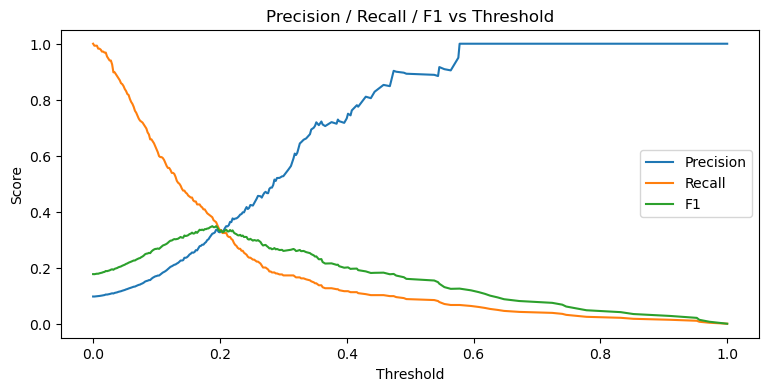

In [14]:
prec, rec, thr = precision_recall_curve(y_test, y_proba)

# thresholds array is length n-1, align with a final point at 1.0
thr = np.append(thr, 1.0)

df_thr = pd.DataFrame({
    "threshold": thr,
    "precision": prec,
    "recall": rec
})
df_thr["f1"] = 2*(df_thr["precision"]*df_thr["recall"]) / (df_thr["precision"]+df_thr["recall"]+1e-9)

display(df_thr.head())

plt.figure(figsize=(9,4))
plt.plot(df_thr["threshold"], df_thr["precision"], label="Precision")
plt.plot(df_thr["threshold"], df_thr["recall"], label="Recall")
plt.plot(df_thr["threshold"], df_thr["f1"], label="F1")
plt.title("Precision / Recall / F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.savefig("Figure 1.png", dpi=200, bbox_inches="tight")
plt.show()



## Threshold that maximizes F1

Best threshold (max F1): 0.194
Accuracy : 0.8682
Precision: 0.3355
Recall   : 0.3627
F1-score : 0.3486


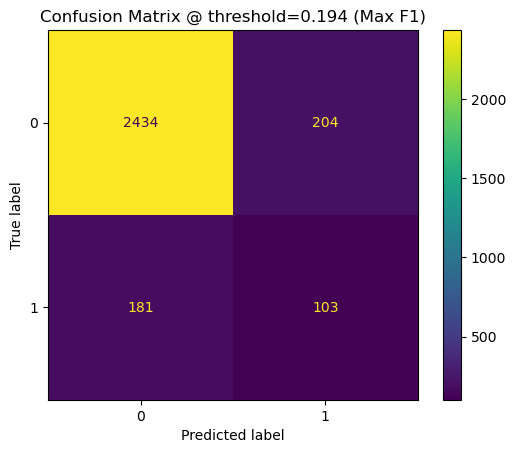

In [15]:
best = df_thr.loc[df_thr["f1"].idxmax()]
best_t = float(best["threshold"])

def eval_at_threshold(y_true, y_prob, t):
    y_pred = (y_prob >= t).astype(int)
    return {
        "threshold": t,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

res_f1 = eval_at_threshold(y_test, y_proba, best_t)

print("Best threshold (max F1):", round(res_f1["threshold"], 4))
print("Accuracy :", round(res_f1["accuracy"], 4))
print("Precision:", round(res_f1["precision"], 4))
print("Recall   :", round(res_f1["recall"], 4))
print("F1-score :", round(res_f1["f1"], 4))

ConfusionMatrixDisplay(confusion_matrix=res_f1["confusion_matrix"]).plot()
plt.title(f"Confusion Matrix @ threshold={best_t:.3f} (Max F1)")
plt.savefig("Figure 2.png", dpi=200, bbox_inches="tight")
plt.show()


# Threshold to hit a Recall target 

Chosen threshold for Recall ≥ 0.70 (best precision): 0.082
Accuracy : 0.5852
Precision: 0.1506
Recall   : 0.7042
F1-score : 0.2481


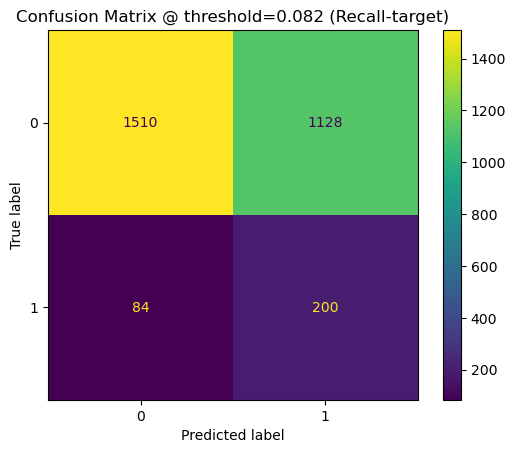

In [16]:
TARGET_RECALL = 0.70

candidates = df_thr[df_thr["recall"] >= TARGET_RECALL].copy()

if len(candidates) == 0:
    print(f"No threshold achieves Recall ≥ {TARGET_RECALL:.2f}")
else:
    chosen = candidates.loc[candidates["precision"].idxmax()]
    t_rec = float(chosen["threshold"])
    res_rec = eval_at_threshold(y_test, y_proba, t_rec)

    print(f"Chosen threshold for Recall ≥ {TARGET_RECALL:.2f} (best precision):", round(t_rec, 4))
    print("Accuracy :", round(res_rec["accuracy"], 4))
    print("Precision:", round(res_rec["precision"], 4))
    print("Recall   :", round(res_rec["recall"], 4))
    print("F1-score :", round(res_rec["f1"], 4))

    ConfusionMatrixDisplay(confusion_matrix=res_rec["confusion_matrix"]).plot()
    plt.title(f"Confusion Matrix @ threshold={t_rec:.3f} (Recall-target)")
    plt.savefig("Figure 3.png", dpi=200, bbox_inches="tight")
    plt.show()


## Threshold comparison table

In [9]:
thresholds_to_compare = [0.5, best_t, 0.10, 0.20, 0.30]
rows = []

for t in thresholds_to_compare:
    r = eval_at_threshold(y_test, y_proba, t)
    cm = r["confusion_matrix"]
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": round(t, 3),
        "accuracy": round(r["accuracy"], 4),
        "precision": round(r["precision"], 4),
        "recall": round(r["recall"], 4),
        "f1": round(r["f1"], 4),
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

df_compare = pd.DataFrame(rows).sort_values("threshold")
display(df_compare)


,threshold,accuracy,precision,recall,f1,TP,FP,FN,TN
2,0.100,0.6680,0.1702,0.6232,0.2674,177,863,107,1775
1,0.194,0.8682,0.3355,0.3627,0.3486,103,204,181,2434
3,0.200,0.8682,0.3265,0.3345,0.3304,95,196,189,2442
4,0.300,0.9045,0.5269,0.1725,0.2599,49,44,235,2594
0,0.500,0.9100,0.8889,0.0845,0.1543,24,3,260,2635


## Business interpretation ("so what?")

- **TP (true positives):** churners we correctly flag for retention
- **FP (false positives):** non-churners we would wrongly target (cost of incentives)
- **FN (false negatives):** churners we miss (lost revenue)
- **TN (true negatives):** correctly left alone

Choosing the threshold is a business decision:
- If incentives are cheap and churn loss is high → choose **lower threshold** (higher recall)
- If incentives are expensive → choose **higher threshold** (higher precision)

Recommendation: start with the **Max-F1 threshold** as a balanced baseline,
then refine based on retention campaign costs and uplift testing.
